<a href="https://colab.research.google.com/github/ah20776/CE807---Assignment/blob/main/CE807_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
#Importing libraries

from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [137]:
# Load news data set
# remove meta data headers footers and quotes from news dataset
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

#
dataset_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=32, remove=('headers', 'footers', 'qutes'))
dataset_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=32, remove=('headers', 'footers', 'qutes'))
# Check the names of the categories
print(dataset.target_names)
print(dataset_train.target_names)
print(dataset_test.target_names)


['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.

In [138]:
# put your data into a dataframe
news_df_train = pd.DataFrame({'News': dataset_train.data,
                       'Target': dataset_train.target})
news_df_test = pd.DataFrame({'News': dataset_test.data,
                       'Target': dataset_test.target})

# get dimensions of data 
print(news_df_train.shape)
print(news_df_train.head())

print(news_df_test.shape)
print(news_df_test.head())

(11314, 2)
                                                News  Target
0  The real question here in my opinion is what M...       4
1  Please could someone in the US give me the cur...       4
2  Can somebody please help me with information a...      12
3  In article <2077@rwing.UUCP> pat@rwing.UUCP (P...      16
4  From article <1pq6i2$a1f@news.ysu.edu>, by ak2...       7
(7532, 2)
                                                News  Target
0  Radio Shack stores sell them here in the State...      12
1  Has anyone else observed this behaviour and if...       2
2  D. Andrew Byler (db7n+@andrew.cmu.edu) wrote:\...      15
3  Again I assume this is not just flame bait by ...      10
4  In article <1993Apr21.100149.1501@rtsg.mot.com...       7


In [139]:
# replace target names from target numbers in our news data frame

news_df_train['Target_name'] = news_df_train['Target'].apply(lambda x: dataset_train.target_names[x])
print(news_df_train.head())
print(news_df_train.shape)

                                                News  ...            Target_name
0  The real question here in my opinion is what M...  ...  comp.sys.mac.hardware
1  Please could someone in the US give me the cur...  ...  comp.sys.mac.hardware
2  Can somebody please help me with information a...  ...        sci.electronics
3  In article <2077@rwing.UUCP> pat@rwing.UUCP (P...  ...     talk.politics.guns
4  From article <1pq6i2$a1f@news.ysu.edu>, by ak2...  ...              rec.autos

[5 rows x 3 columns]
(11314, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

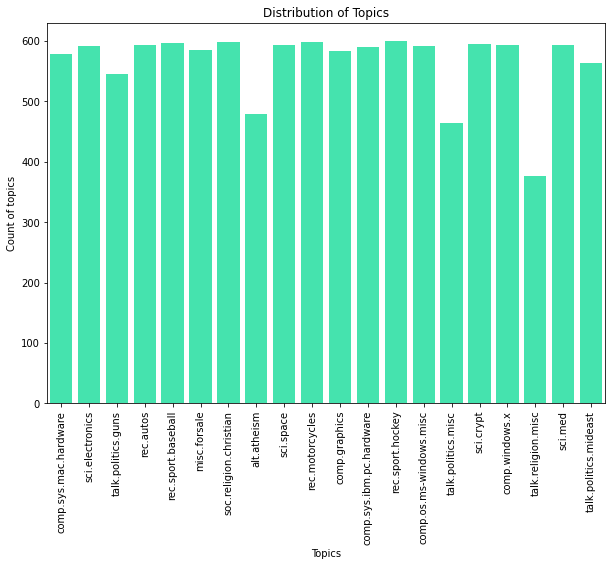

In [140]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(news_df_train['Target_name'], color=sns.xkcd_rgb['greenish cyan'])
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)

In [141]:
# clean text data
# remove non alphabetic characters
# remove stopwords and lemmatize

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    # puctuation
    #punct = set(string.punctuation)
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]

    # remove punctuation
    #word_list = [word for word in word_list if word not in punct]
    
    # stemming
    # ps  = PorterStemmer()
    # word_list = [ps.stem(word) for word in word_list]
    
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence

# we'll use tqdm to monitor progress of data cleaning process
# create tqdm for pandas
tqdm.pandas()
# clean text data

news_df_train['News'] = news_df_train['News'].progress_apply(lambda x: clean_text(str(x)))
print(news_df_train.head())

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 11314/11314 [00:17<00:00, 634.71it/s]

                                                News  ...            Target_name
0  real question opinion motorola processor runni...  ...  comp.sys.mac.hardware
1  please could someone give current street price...  ...  comp.sys.mac.hardware
2  somebody please help information american magn...  ...        sci.electronics
3  article rwing uucp pat rwing uucp pat myrto wr...  ...     talk.politics.guns
4  article news ysu edu yfn ysu edu john daker cu...  ...              rec.autos

[5 rows x 3 columns]


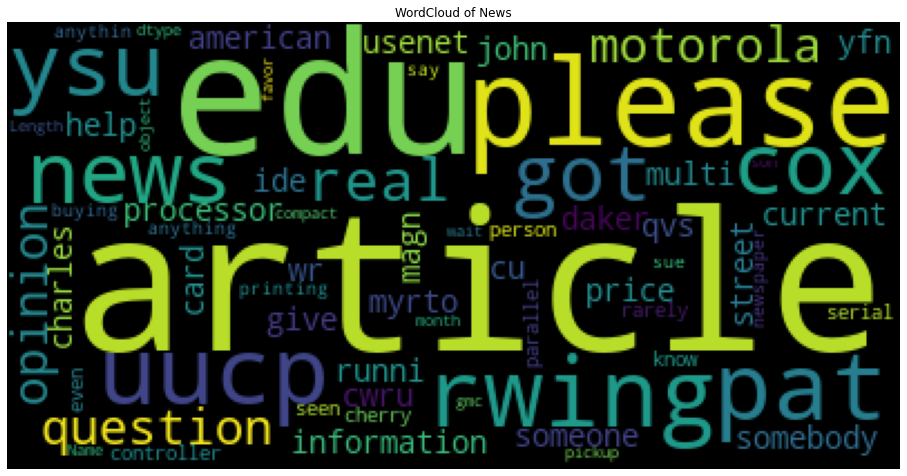

In [142]:
# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df_train['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#not very useful

Vectorizing

In [143]:
# Let's start getting some features
count_vect = CountVectorizer()
news_df_train_counts = count_vect.fit_transform(news_df_train['News'])
news_df_train_counts.shape
#the output is term-document matrix size

(11314, 73382)

Tfidf

In [144]:
# here we use tf-idf features
tfidf_transformer = TfidfTransformer()
news_df_train_tfidf = tfidf_transformer.fit_transform(news_df_train_counts)
news_df_train_tfidf.shape

(11314, 73382)

Latent Dirichlet Allocation (LDA)

In [145]:
lda_model = LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(news_df_train_tfidf)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=12, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


Similar way using pipeline

'''lda_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('lda', LatentDirichletAllocation(n_components=20,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50))])

lda_model = lda_model.fit(news_df_train['News'], news_df_train['Target'])

print(lda_model)  # Model attributes'''

Got error while taking Perplexity

In [150]:
lda_model.components_.shape

(20, 73382)

In [152]:
doc_topic_lda = lda_model.transform(news_df_train_tfidf)
doc_topic_lda.shape

(11314, 20)

In [154]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:10].index)
        
    return word2topics

In [158]:
terms = count_vect.get_feature_names()
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Topics		Words
topic 0 	 ['pyeatt', 'glxmdraw', 'texaco', 'glxgetconfig', 'glxwinset', 'glxunlink', 'glxdraw', 'glxlink', 'grayhill', 'waldbronn']
topic 1 	 ['burzynski', 'apkp', 'ffa', 'antineoplastons', 'jschwimmer', 'oncologist', 'apleftbox', 'apgrow', 'apedit', 'apcmd']
topic 2 	 ['edu', 'would', 'one', 'writes', 'com', 'article', 'know', 'like', 'get', 'people']
topic 3 	 ['drexel', 'cbis', 'wetstein', 'hlvs', 'jpw', 'dtv', 'dbf', 'pntr', 'sele', 'ntreal']
topic 4 	 ['knbr', 'fdd', 'frisco', 'frode', 'critus', 'vedic', 'rama', 'smc', 'trondheim', 'kvam']
topic 5 	 ['adventurer', 'andranik', 'sarikamish', 'arfa', 'bok', 'rogerw', 'tiawan', 'equptment', 'armenian', 'belligerence']
topic 6 	 ['lonoak', 'outfitting', 'reingold', 'participaants', 'boole', 'dcookson', 'faceshield', 'kotnml', 'wibbling', 'flicked']
topic 7 	 ['whatta', 'melittin', 'regina', 'parentcvtargs', 'alboum', 'xmucvtstringtowidget', 'myproggy', 'xtrstring', 'xtrwidget', 'intrinsicsp']
topic 8 	 ['spacious', 'micro